# What's In My Neighborhood

This note book gets data from the Minnesota Pollution Control Agency's [What's in My Neighborhood Sites](https://www.pca.state.mn.us/data/whats-my-neighborhood) database published to the [Minnestota Geospatial Commons,](https://gisdata.mn.gov/dataset/env-my-neighborhood) clips the data to Minneapolis boundaries, edits the entries for clarity by removing missing or mislabeled data and eliminating extraneaous information, and saves the file as a geojson. (hopefully)

**Downloaded Data Info:**

<!-- CRS: WGS84 - epsg:4326 -->

Size: 

**Saved Data Info:**

<!-- CRS: NAD83, UTM zone 15N -- epsg:26915
    
Size: 4.1mb -->

Source: https://gisdata.mn.gov/dataset/env-my-neighborhood

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
### Definitions

files_before = os.listdir() # Get filenames in working directory so they aren't deleted at the end.
cwd = os.getcwd() # Current Working Directory

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(urls=None):
    '''Extract a zipfile from the internet and unpack it in working directory.
    Takes a single url (string) or a list of urls.'''
    
    if type(urls) == str: # Single url
        url = urls
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall() # Extract files
        zip_folder.close()
    
    elif type(urls) == list: # List of urls
        for url in urls:
            response = urllib.request.urlopen(url) # Get a response
            zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
            zip_folder.extractall() # Extract files
            zip_folder.close()
            
    else:
        print('Error Extracting: Invalid Input')

def clip_to_extent(gdf):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will access the geojson of Minneapolis from GitHub if it's not in the current working directory or local Boundary folder.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Look for mpls_boundary
    
    cwd = os.getcwd() # Current working directory

    os.chdir('..') # Bump up one directory

    if 'mpls_boundary.shp' in os.listdir(cwd): # Boundary shapefile in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.shp') # Load extent as GeoDataFrame

    elif 'mpls_boundary.geojson' in os.listdir(cwd): # Boundary json in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.geojson') # Load extent as GeoDataFrame

    elif 'Boundary' in os.listdir(): # Boundary folder on computer
        if 'mpls_boundary.geojson' in os.listdir('Boundary'): # Is the json there?
            path = 'Boundary' + slash + 'mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(path)

        else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame
    else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame


    os.chdir(cwd) # Go back to current working directory
    
    if gdf.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        gdf = gdf.to_crs('EPSG:26915')
    
    clipped = gpd.clip(gdf, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

In [3]:
### Load Data

## What's In My Neighborhood

if 'csv_env_my_neighborhood.zip' not in os.listdir():
    print('''Downloaded current state data from MPCA (~40.6 mb)\n
    format: .csv''')
    url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_pca/env_my_neighborhood/csv_env_my_neighborhood.zip'
    extract_zip_from_url(url)
    my_nabe_df = pd.read_csv("my_neighborhood_sites.csv") # Load as DataFrame

else:
    print('You already have my_neighborhood_sites.csv. Please skip to the next notebook.')

Downloaded current state data from MPCA (~40.6 mb)

    format: .csv


In [4]:
# my_nabe_df.info()

In [5]:
my_nabe_df.sample(6
                 )

,objectid,site_id,name,active_flag,address_street,address_city,address_state,address_zip,city,county,...,program_code_list,program_name,program_name_list,industrial_classification,ic_flag,latitude,longitude,coord_collect_method_code,coord_collect_method_name,shape
100663,100638,188304,International Falls City Garage,Y,7th St W & 2nd Ave E,International Falls,MN,56649,International Falls,Koochiching,...,SR,Investigation and Cleanup,Investigation and Cleanup,NaN,N,48.598411,-93.402066,A1,Address Matching House Number,0101000020E61000008ED59C72BB5957C0DC46A8BE984C...
176904,176903,125456,French Antiques,Y,3016 Lyndale Ave S,Minneapolis,MN,55408,Minneapolis,Hennepin,...,TL,Tanks,Tanks,NaN,N,44.947688,-93.288440,DM,Digitized - MPCA internal map,0101000020E6100000EDB60BCD755257C026299FD44D79...
119940,119926,63627,Dennis Milbrett Farm,Y,21731 260th St,New Ulm,MN,56073,Milford Township,Brown,...,FE,Feedlots,Feedlots,NaN,N,44.340507,-94.609913,A1,Address Matching House Number,0101000020E6100000AB4A11CF08A757C09CA8A5B9952B...
166213,166207,52305,Leo Klaers Farm,N,14462 175th St,Watkins,MN,55389,Luxemburg Township,Stearns,...,FE,Feedlots,Feedlots,NaN,N,45.379039,-94.408138,I2,Digitized-DOQ,0101000020E61000009702B1F01E9A57C0C240425A84B0...
443,433,74655,Harold Emde Farm,N,Address Unknown,Mantorville,MN,55955,Westfield Township,Dodge,...,FE,Feedlots,Feedlots,NaN,N,43.921870,-93.007866,DM,Digitized - MPCA internal map,0101000020E6100000063065E0804057C01814BCD7FFF5...
105082,105060,126484,2007 Sanitary Sewer & Lift Station,Y,See location description,Park Rapids,MN,56470,Arago Township,Hubbard,...,ST,Stormwater,Stormwater,NaN,N,47.060318,-95.121926,Q2,Public Land Survey-Two Quarter,0101000020E61000002C95E0A2CDC757C0D7EC9282B887...


In [13]:
# cast dataframe as geodataframe 
my_nabe_gdf = gpd.GeoDataFrame(
    my_nabe_df, geometry=gpd.points_from_xy(my_nabe_df.longitude, my_nabe_df.latitude))

#set CRS to NAD 83/ UTM zone 15

my_nabe_gdf = my_nabe_gdf.set_crs('EPSG:4326')

my_nabe_gdf.head()
my_nabe_gdf.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

* OG df did not contain crs info, and has shape info, wondering if treating this like point data in a gdf is best practice
* also, looks to be many diff coordinate collection methods and likely various degrees of accuracy.

In [24]:
#clip data set to MPLS boundary

my_nabe_clp, mpls_boundary = clip_to_extent(my_nabe_gdf)


<AxesSubplot:>

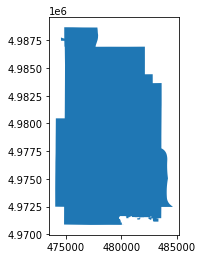

In [29]:

mpls_boundary.plot()

In [30]:
my_nabe_clp_gdf


,objectid,site_id,name,active_flag,address_street,address_city,address_state,address_zip,city,county,...,program_name,program_name_list,industrial_classification,ic_flag,latitude,longitude,coord_collect_method_code,coord_collect_method_name,shape,geometry
158801,158784,147597,Saint Kevins School,N,5752 27th Ave S,Minneapolis,MN,55417,Minneapolis,Hennepin,...,Tanks,Tanks,NaN,N,44.898930,-93.233718,A1,Address Matching House Number,0101000020E61000004D1E053EF54E57C06FF4311F1073...,POINT (-93.23372 44.89893)
23277,23251,216051,Looking Good Decorating,Y,5657 26th Ave S,Minneapolis,MN,55417-2742,Minneapolis,Hennepin,...,Hazardous Waste,Hazardous Waste,Painting and Wall Covering Contractors,N,44.900153,-93.235259,DP,Digitized - MPCA online map,0101000020E6100000BDC5C37B0E4F57C0BA32A8363873...,POINT (-93.23526 44.90015)
130916,130895,140705,QJKL12-0001 Repair Aircraft Parking Apro,N,760 Military Hwy,Minneapolis,MN,55450-2100,Minneapolis,Hennepin,...,Stormwater,Stormwater,NaN,N,44.893500,-93.213200,I2,Digitized-DOQ,0101000020E610000076E09C11A54D57C0EE7C3F355E72...,POINT (-93.21320 44.89350)
139239,139206,139389,QJKL11-003 Repair Aircraft Parking Apron,N,Address Unknown,Minneapolis,MN,55450,Minneapolis,Hennepin,...,Stormwater,Stormwater,NaN,N,44.893500,-93.213800,G8,GPS - Other,0101000020E6100000A1F831E6AE4D57C0EE7C3F355E72...,POINT (-93.21380 44.89350)
23207,23179,193827,Minneapolis US Air Force Reserve,Y,760 Military Highway,Minneapolis,MN,55450,Minneapolis,Hennepin,...,Investigation and Cleanup,Investigation and Cleanup,NaN,N,44.893832,-93.214373,DM,Digitized - MPCA internal map,0101000020E61000007888354BB84D57C08F4F6D156972...,POINT (-93.21437 44.89383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170782,170762,34597,SSJS Inc dba Warning Lites of MN,Y,4700 Lyndale Ave N,Minneapolis,MN,55430,Minneapolis,Hennepin,...,Multiple Programs,Hazardous Waste; Tanks,Marketing Research and Public Opinion Polling,N,45.040357,-93.287118,A1,Address Matching House Number,0101000020E6100000BD659824605257C0D2D3916D2A85...,POINT (-93.28712 45.04036)
130149,130123,20007,United Rentals Hwy Technologies,Y,4754 Lyndale Ave N,Minneapolis,MN,55430,Minneapolis,Hennepin,...,Hazardous Waste,Hazardous Waste,NaN,N,45.041124,-93.287034,A1,Address Matching House Number,0101000020E6100000ED3488C55E5257C0E949F48D4385...,POINT (-93.28703 45.04112)
2972,2950,14917,Lens Garage,Y,4835 Lyndale Ave N,Minneapolis,MN,55430-3639,Minneapolis,Hennepin,...,Hazardous Waste,Hazardous Waste,"Automotive Body, Paint, and Interior Repair an...",N,45.042807,-93.286638,A1,Address Matching House Number,0101000020E610000091D10149585257C0AF44FBB37A85...,POINT (-93.28664 45.04281)
34400,34377,56275,Biernat Printing - Lyndale,Y,4831 Lyndale Ave N,Minneapolis,MN,55430,Minneapolis,Hennepin,...,Hazardous Waste,Hazardous Waste,NaN,N,45.042882,-93.286203,A1,Address Matching House Number,0101000020E610000018416326515257C03D0D18247D85...,POINT (-93.28620 45.04288)
